# AirBNB Price Prediction (linear regression)

In [1]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X(df):
    X = df.copy()
    X.reviews_per_month = X.reviews_per_month.fillna(0).values
    return X

def split_data(df, seed):    
    # split dataset indexes into 60%-20%-20%
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    # shuffle index
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    # split dataset
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    # reset index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # save price in natural logarithm form (1 + log)
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values) 
    y_test = np.log1p(df_test.price.values)

    # remove target column price from dataset
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    return df_train, df_val, df_test, y_train, y_val, y_test

## Read Data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('AB_NYC_2019.csv')

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Data preparation

In [3]:
def prepare_data(column):
    return column.str.lower().str.replace(' ', '_')

# prepare column names
df.columns = prepare_data(df.columns)

df = df.drop(columns=[
    "id",
    "name",
    "host_id", 
    "host_name", 
    "neighbourhood_group", 
    "neighbourhood",
    "room_type",
    "last_review"
], axis = 1)

## Exploratory data analysis

<AxesSubplot:xlabel='price', ylabel='Count'>

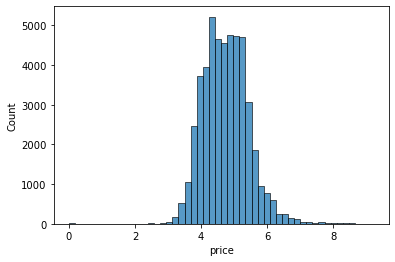

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

price_logs = np.log1p(df.price)
sns.histplot(
    price_logs, 
    bins=50
)

### Question 1

Find a feature with missing values. How many missing values does it have?

In [5]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [6]:
df.minimum_nights.median()

3.0

## Validation framework

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lesssons.
* For computing the mean, use the training only!
* Compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

## Training a linear regression model

#### Training a linear regression model with fillna 0

RMSE with 0: 0.6428860484860399
RMSE rounded with 0: 0.64


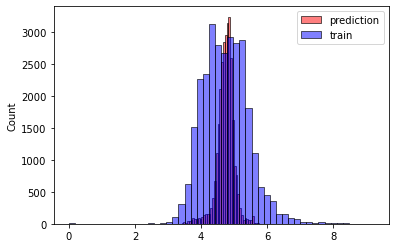

In [7]:
seed = 42
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)

X_train = df_train

X_train.reviews_per_month = X_train.reviews_per_month.fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

sns.histplot(y_pred, label="prediction", color='red', alpha=0.5, bins=50)
sns.histplot(y_train, label="train", color='blue', alpha=0.5, bins=50)
plt.legend()

rmse_0 = rmse(y_train, y_pred)

print("RMSE with 0: {0}".format(rmse_0))
print("RMSE rounded with 0: {0}".format(round(rmse_0, 2)))

#### Training a linesr regression model with fillna mean

RMSE with mean: 0.64


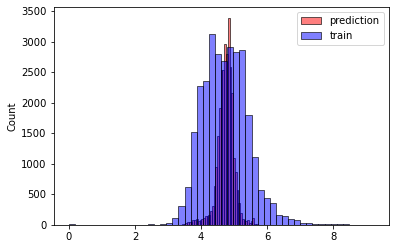

In [8]:
seed = 42
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)

X_train = df_train
reviews_mean = X_train.reviews_per_month.mean()
X_train.reviews_per_month = X_train.reviews_per_month.fillna(reviews_mean).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

sns.histplot(y_pred, label="prediction", color='red', alpha=0.5, bins=50)
sns.histplot(y_train, label="train", color='blue', alpha=0.5, bins=50)
plt.legend()

rmse_mean = round(rmse(y_train, y_pred), 2)
print("RMSE with mean: {0}".format(rmse_mean))

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [9]:
seed = 42
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)

def calculate_rmse(r):
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    return round(rmse(y_val, y_pred), 2)

rmse_list = list(map(calculate_rmse, [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]))
print([0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10])
rmse_list

[0, 1e-06, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]


[0.64, 0.64, 0.64, 0.64, 0.66, 0.68, 0.68, 0.68, 0.68]

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


In [10]:
def calc_rmse_score(seed):    
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)

    X_train = df_train
    X_train.reviews_per_month = X_train.reviews_per_month.fillna(0).values

    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_train.dot(w)

    return rmse(y_train, y_pred)

round(
    np.std(
        list(
            map(calc_rmse_score, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        )
    )
    ,
    3
)

0.004

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Train a model with `r=0.001`.
* What's the RMSE on test dataset?

In [13]:
def calc_rmse_score_full(seed):
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)
    
    # prepare train
    df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
    X_full_train = prepare_X(df_full_train)
    y_full_train = np.concatenate([y_train, y_val])

    # run linear regression
    w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

    # test and show scores
    X_test = prepare_X(df_test)
    y_pred = w0 + X_test.dot(w)
    return rmse(y_test, y_pred)


round(calc_rmse_score_full(9), 2)

0.65